In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import json
import requests
import timeit

## 1 Read in data
### 1.1 Make API request for WFP Data

In [3]:
small_url = "https://data.humdata.org/api/action/datastore_search?resource_id=12d7c8e3-eff9-4db0-93b7-726825c4fe9a&limit=1"
small_r = requests.get(small_url)
num_records = small_r.json()['result']['total']

url = "https://data.humdata.org/api/action/datastore_search?resource_id=12d7c8e3-eff9-4db0-93b7-726825c4fe9a&limit=" + str(num_records)
r = requests.get(url)
wfp_df = pd.DataFrame(r.json()['result']['records'])

### 1.2. Limit data to countries of interest, remove and rename columns

In [4]:
gdf = gpd.read_file("regions.geojson")
countries = gdf['ADMIN0'].value_counts().index.tolist()
wfp_df = wfp_df[wfp_df['adm0_name'].isin(countries)]

cols = [c for c in wfp_df.columns if c.lower()[-3:] != '_id']
wfp_df = wfp_df[cols].drop(columns=['mp_commoditysource'])
wfp_df = wfp_df.rename(columns={
    "adm0_name": "ADMIN0", 
    "adm1_name": "ADMIN1",
    "cm_name": "commodity",
    "cur_name": "currency",
    "pt_name": "mkt_type",
    "um_name": "unit_measure",
    "mp_month": "month",
    "mp_year": "year",
    "mp_price": "price"
})

### 1.3 Clean WFP ADMIN1 names to match hunger score geojson format
I copied Matt's code from the `population_wrangling.ipynb` in order to catch mismatched admin1 zone names. There were a few that I saw on a manual check that I added to the match translation dictionary.

In [17]:
import Levenshtein as lev

zones_m = gdf['ADMIN1'].unique()
zones_j = wfp_df['ADMIN1'].unique()
wrong_zones = set(zones_j) - set(zones_m)
lev.ratio('aa', 'ab')

def find_matches(correct_zones, wrong_zones):
    zone_matches = {
        'Juba Dhexe': 'Middle Juba',
        'Juba Hoose': 'Lower Juba',
        'Shabelle Dhexe': 'Middle Shabelle',
        'Shabelle Hoose': 'Lower Shabelle',
    }

    for z1 in zones_m:
        for z2 in wrong_zones:
            if lev.ratio(z1, z2) > 0.8:
                zone_matches[z2] = z1 

    for key in zone_matches.keys():
        print(key, '----', zone_matches[key])
    return zone_matches

zone_matches = find_matches(zones_m, wrong_zones)

def link(zone, zone_matches):
    if zone in zone_matches:
        correct_zone = zone_matches[zone]
        return correct_zone
    else:
        return zone
    
wfp_df['ADMIN1'] = wfp_df['ADMIN1'].map(lambda x: link(x, zone_matches))

Juba Dhexe ---- Middle Juba
Juba Hoose ---- Lower Juba
Shabelle Dhexe ---- Middle Shabelle
Shabelle Hoose ---- Lower Shabelle
Beneshangul Gumu ---- Benshangul Gumuz
Banadir ---- Banaadir
Hiraan ---- Hiiraan


## 2. Clean data
### 2.1 Commodity names, units of measurement
All commodity names include whether the price is retail or wholesale, but this information is already available in the mkt_type column. Clean commodity names to remove unnecessary information, see which crops are most prominent.

In [18]:
wfp_df.commodity = wfp_df.commodity.str.split(" - ", expand = True)[0]

In [19]:
wfp_df.unit_measure.value_counts()

KG           27205
100 KG        6182
90 KG         5842
L             5113
3.5 KG        5069
3 KG          3365
MT            2379
USD/LCU       1332
50 KG          836
Head           522
Unit           446
Day            181
400 G          169
500 ML         169
LCU/3.5kg       46
Name: unit_measure, dtype: int64

The most common unit of measurement is KG - limit dataset to only include crops which are measured in KG, and change prices to reflect price per KG (instead of price per 100 KG or per 90 KG). Include the MT unit of measurement since it is a metric ton.

Justification to drop other units of measurement:
* L - used for oil, fuel, milk, and ground nuts (in one case).
* USD/LCU - exchange rates for Somalia, South Sudan, and Ethiopia. Will reference an external dataset for conversion instead.
* Head and Unit -  used for livestock
* Day - used for wages
* "500 ML" and "400 G" - 169 instances each, used for milk and bread in Nairobi
* LCU/3.5kg - used for milling cost

In [20]:
# Remove rows that do not use kilograms
has_kg = wfp_df.unit_measure.str.contains('KG')
is_metric_ton = wfp_df.unit_measure == 'MT'
wfp_df = wfp_df[has_kg | is_metric_ton]

# Convert to price per kilogram
unit_convert = {
    "KG": 1,
    "100 KG": 1./100,
    "90 KG": 1./90,
    "3.5 KG": 1/3.5,
    "3 KG": 1./3,
    "MT": 1./1000,
    "50 KG": 1./50
}

def convert_to_kg(row):
    new_price = row.price * unit_convert[row.unit_measure]
    row["price_per_kg"] = new_price
    return row

wfp_df = wfp_df.apply(convert_to_kg, axis=1).drop(columns=["unit_measure", "price"])
wfp_df.head()

,ADMIN0,ADMIN1,mkt_name,commodity,currency,mkt_type,month,year,price_per_kg
92294,Ethiopia,Addis Ababa,Addis Ababa,Teff,ETB,Wholesale,12,2012,13.085
92295,Ethiopia,Addis Ababa,Addis Ababa,Teff,ETB,Wholesale,1,2013,12.570
92296,Ethiopia,Addis Ababa,Addis Ababa,Teff,ETB,Wholesale,2,2013,13.000
92297,Ethiopia,Addis Ababa,Addis Ababa,Teff,ETB,Wholesale,3,2013,12.998
92298,Ethiopia,Addis Ababa,Addis Ababa,Teff,ETB,Wholesale,4,2013,13.075


### 2.2 Standardize prices
The earliest hunger score data we have is from 2009, but we are going to use 5 year averages to standardize commodity prices - so we need data from 2004 onwards.

Creating a column to denote time as year + percentage of year elapsed (based on month) for easier filtering.

In [21]:
wfp_df = wfp_df[wfp_df.year >= 2004]
wfp_df['years_only'] = wfp_df['year'] + pd.to_numeric(wfp_df['month']) / 13.

I tried finding packages to convert currencies to USD based off of monthly exchange rates, but the well-supported packages (e.g. forex-python) seem to only have data from Europe/major participants in the foreign exchange market.

The African Development Bank Group (ADBG) publishes monthly Excel spreadsheets with exchange rates for our time period of interest, but it would be pretty time intensive to download, clean, and integrate all of the .xlsx files. https://www.afdb.org/en/documents/financial-information/exchange-rates  

Instead, I will calculate the percentage difference from each market's listed monthly price for a commodity and the country-wide average price for the commodity over the most recent 5 years.

In [22]:
def calculate_percent_diff(row, commodity_df):
    # Don't calculate for prices that were measured before 2009
    percent_diff_from_5yr_avg = np.nan
    if row['year'] > 2009:
        # Select data for the 5 years immediately preceding this recording of market price
        from_prev_5yr = commodity_df[
            (commodity_df['years_only'] < row['years_only']) & (
            commodity_df['years_only'] >= row['years_only'] - 5)]
        # Don't calculate the percentage price difference if there are not over 50 
        # previous data points to average across
        if len(from_prev_5yr) >= 50: 
            avg = from_prev_5yr['price_per_kg'].mean()
            percent_diff_from_5yr_avg = (row['price_per_kg'] - avg) / avg
    row['pd_5yr'] = percent_diff_from_5yr_avg
    return row

def get_perc_diff(commodity_df): 
    ADMIN0 = commodity_df['ADMIN0'].iloc[0]
    commodity = commodity_df['commodity'].iloc[0]
    currency = commodity_df['currency'].iloc[0]
    mkt_type = commodity_df['mkt_type'].iloc[0]
    print_str = "Adding percentage differences for {}, {}, {}, {}".format(
        ADMIN0, commodity, currency, mkt_type)
    print(print_str)
    
    commodity_df = commodity_df.apply(lambda row: calculate_percent_diff(row, commodity_df), axis=1)
    return commodity_df


criteria = ['ADMIN0', 'commodity', 'currency', 'mkt_type']

start = timeit.default_timer()
wfp_df = wfp_df.groupby(criteria).apply(lambda group: get_perc_diff(group))
stop = timeit.default_timer()
print('Time: ', stop - start, "seconds")

Adding percentage differences for Ethiopia, Barley, ETB, Retail
Adding percentage differences for Ethiopia, Beans (fava, dry), ETB, Retail
Adding percentage differences for Ethiopia, Beans (haricot), ETB, Retail
Adding percentage differences for Ethiopia, Chickpeas, ETB, Retail
Adding percentage differences for Ethiopia, Corn Soy Blend (CSB++, food aid), ETB, Retail
Adding percentage differences for Ethiopia, Lentils, ETB, Retail
Adding percentage differences for Ethiopia, Maize (white), ETB, Retail
Adding percentage differences for Ethiopia, Maize (white), ETB, Wholesale
Adding percentage differences for Ethiopia, Pasta, ETB, Retail
Adding percentage differences for Ethiopia, Peas (green, dry), ETB, Retail
Adding percentage differences for Ethiopia, Rice (imported), ETB, Retail
Adding percentage differences for Ethiopia, Sorghum, ETB, Retail
Adding percentage differences for Ethiopia, Sorghum, ETB, Wholesale
Adding percentage differences for Ethiopia, Sorghum (red), ETB, Wholesale
Add

In [23]:
# Drop rows for which we did not have enough data to calculate the 
# country-wide 5 year average for that commodity.
wfp_df = wfp_df.dropna()

### 2.3 Examine differences in pricing trends for retail vs. wholesale markets
Wholesale markets overall have much greater stability than retail markets. There also seems to have been some sort of retail price shock in 2018.

             pd_5yr                                
                min         max      mean       var
mkt_type                                           
Retail    -0.960617  226.843953  0.500607  7.255837
Wholesale -0.682036    4.624060  0.350892  0.257526


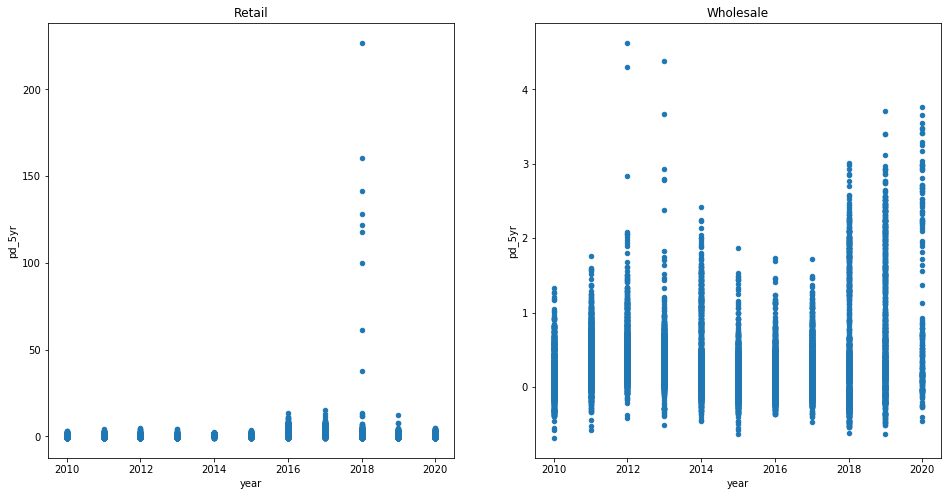

In [24]:
grouped = wfp_df.groupby('mkt_type')
print(grouped.agg({'pd_5yr': ['min', 'max', 'mean', 'var']}))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    group_df = grouped.get_group(key)
    ax.title.set_text(key)
    group_df.plot(x='year', y='pd_5yr', ax=ax, kind='scatter')
plt.show()

In [25]:
wfp_outliers = wfp_df[wfp_df['pd_5yr'] >= 20]
wfp_outliers

,ADMIN0,ADMIN1,mkt_name,commodity,currency,mkt_type,month,year,price_per_kg,years_only,pd_5yr
122304,Ethiopia,Somali,Gode,Rice (imported),ETB,Retail,6,2018,2400.0,2018.461538,128.352895
122305,Ethiopia,Somali,Gode,Rice (imported),ETB,Retail,7,2018,2700.0,2018.538462,61.556430
122306,Ethiopia,Somali,Gode,Rice (imported),ETB,Retail,8,2018,2700.0,2018.615385,37.690795
122425,Ethiopia,Somali,Gode,Sorghum,ETB,Retail,6,2018,2000.0,2018.461538,226.843953
122426,Ethiopia,Somali,Gode,Sorghum,ETB,Retail,7,2018,2000.0,2018.538462,160.192360
122427,Ethiopia,Somali,Gode,Sorghum,ETB,Retail,8,2018,2000.0,2018.615385,121.681974
122562,Ethiopia,Somali,Gode,Maize (white),ETB,Retail,6,2018,1000.0,2018.461538,141.422253
122563,Ethiopia,Somali,Gode,Maize (white),ETB,Retail,7,2018,1000.0,2018.538462,117.586111
122564,Ethiopia,Somali,Gode,Maize (white),ETB,Retail,8,2018,1000.0,2018.615385,99.879027


There seems to be something that happened in Ethiopia from June - August of 2018 to cause a large price increase. I am skeptical that these are accurate because the numbers are so round, and the prices for some of these commodities come out to over 70USD/kilogram. I am going to drop these values.

             pd_5yr                               
                min        max      mean       var
mkt_type                                          
Retail    -0.960617  15.348883  0.457137  1.026226
Wholesale -0.682036   4.624060  0.350892  0.257526


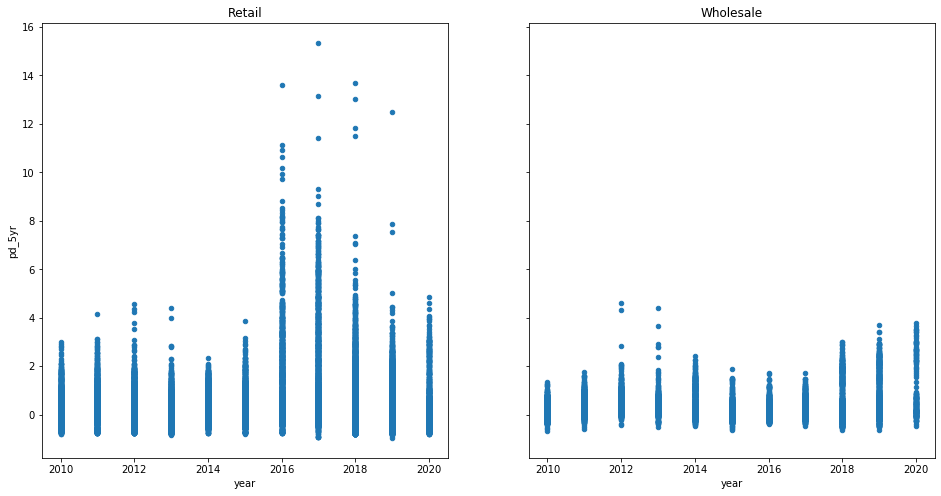

In [26]:
wfp_df = wfp_df[wfp_df['pd_5yr'] < 20]
grouped = wfp_df.groupby('mkt_type')
print(grouped.agg({'pd_5yr': ['min', 'max', 'mean', 'var']}))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)
for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    group_df = grouped.get_group(key)
    ax.title.set_text(key)
    group_df.plot(x='year', y='pd_5yr', ax=ax, kind='scatter')
plt.show()

Wholesale prices still remain much more stable than retail prices. It's interesting to note that retail prices grew the most in 2016-2017, but wholesale prices grew the least during this same time period. I think we need to consider the difference in price stability, and either have two separate models for wholesale/retail prices, or just limit the scope of our pricing data to just retail prices.

### 2.4 Determine approach to different commodities
* Is there enough data for a certain commodity within each of the admin zones to drop other commodities?
* What pricing differences are there between different commodities? Can commodities be grouped? 

In [27]:
# Select top 12 groups
commodity_groups = ['Maize', 'Sorghum', 'Wheat', 'Millet', 'Rice', 
                    'Bean', 'Cassava', 'Groundnut', 'Potato', 'Teff',
                    'Pasta', 'Sesame']

# Add column creating commodity groups
def get_commodity_group(commodity):
    c_group = np.nan
    for group_name in commodity_groups:
        if group_name in commodity:
            c_group = group_name
    return c_group

pd.options.mode.chained_assignment = None
wfp_df['commodity_group'] = wfp_df['commodity'].apply(get_commodity_group)

# Drop observations which do not fall within our commodity groups, drop unused columns
wfp_df = wfp_df.dropna()
wfp_df = wfp_df.drop(columns=['commodity', 'currency', 'years_only', 'price_per_kg'])


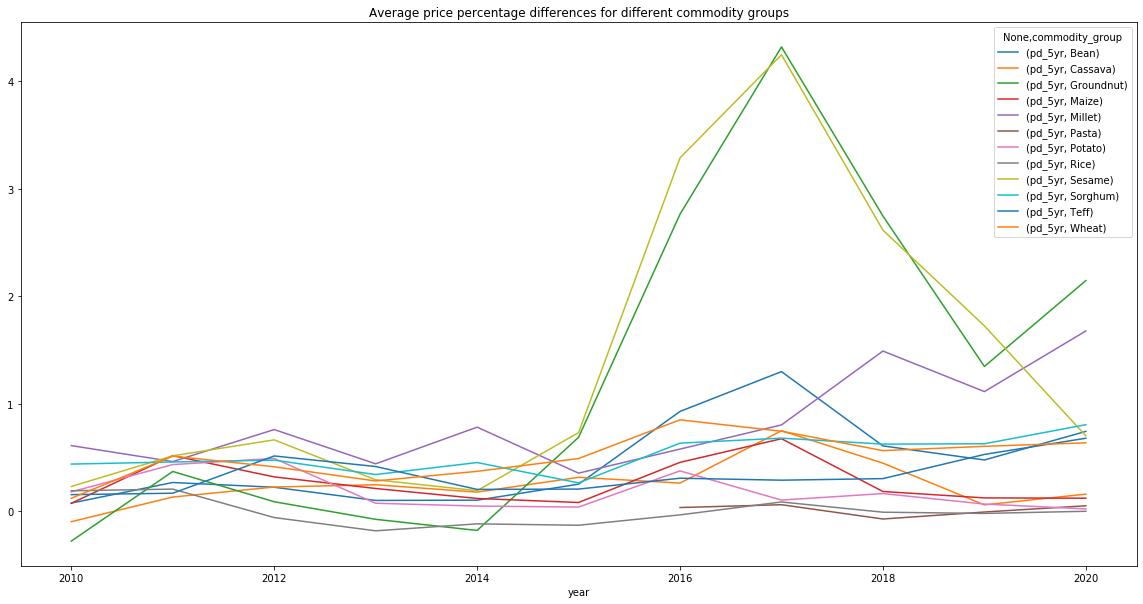

In [28]:
c_groups = wfp_df.groupby(['year', 'commodity_group']).agg({'pd_5yr': 'mean'})

fig, ax = plt.subplots(figsize=(20,10))
c_groups.unstack().plot(ax=ax)
plt.title("Average price percentage differences for different commodity groups")
plt.show()

It looks like ground nut products and sesame products are outliers - I'm going to remove these from the data.

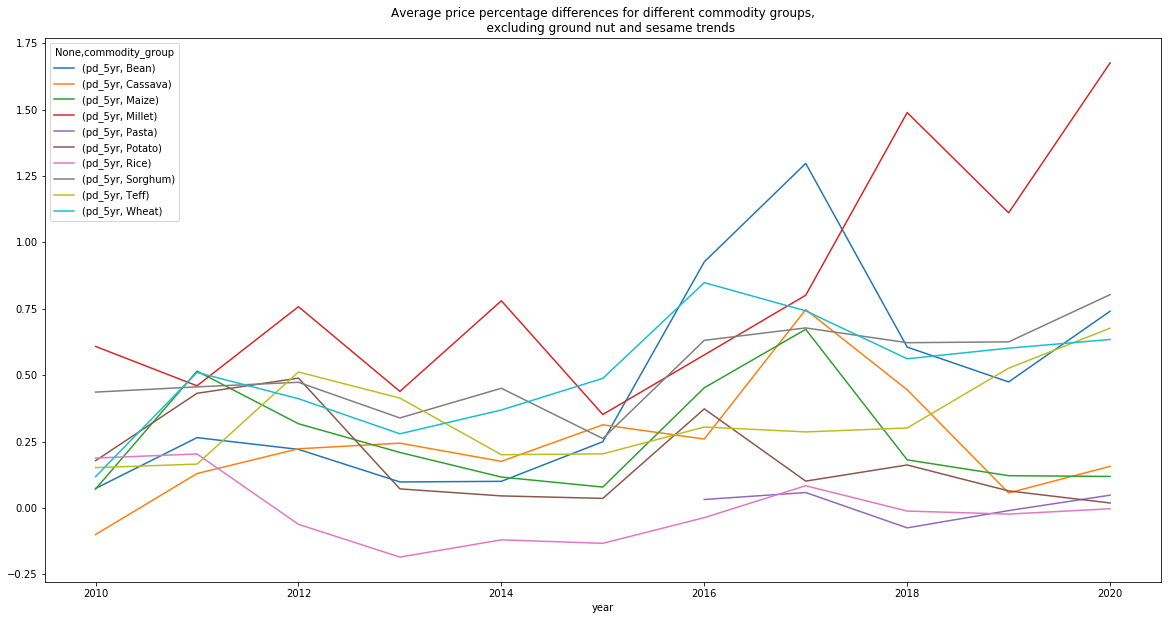

In [29]:
wfp_df = wfp_df[
    (wfp_df['commodity_group'] != 'Groundnut') & 
    (wfp_df['commodity_group'] != 'Sesame')]

c_groups = wfp_df.groupby(['year', 'commodity_group']).agg({'pd_5yr': 'mean'})
fig, ax = plt.subplots(figsize=(20,10))
c_groups.unstack().plot(ax=ax)
plt.title("""Average price percentage differences for different commodity groups,
    excluding ground nut and sesame trends""")
plt.show()

### 2.5 Average prices across markets within an ADMIN1 zone

In [30]:
criteria = ['ADMIN0', 'ADMIN1', 'year', 'month', 'mkt_type', 'commodity_group']
wfp_df = wfp_df.groupby(criteria).agg({'pd_5yr': 'mean'}).reset_index()
wfp_df.head(5)

,ADMIN0,ADMIN1,year,month,mkt_type,commodity_group,pd_5yr
0,Ethiopia,Addis Ababa,2010,1,Wholesale,Maize,0.205705
1,Ethiopia,Addis Ababa,2010,1,Wholesale,Sorghum,0.411758
2,Ethiopia,Addis Ababa,2010,1,Wholesale,Teff,0.505039
3,Ethiopia,Addis Ababa,2010,1,Wholesale,Wheat,0.493503
4,Ethiopia,Addis Ababa,2010,10,Wholesale,Maize,-0.118410


Create columns for each combination of commodity group and market type and save.

In [32]:
criteria = ['ADMIN0', 'ADMIN1', 'year', 'month']
df = wfp_df.pivot_table(
        values='pd_5yr', 
        index=criteria, 
        columns=['mkt_type', 'commodity_group'], 
        aggfunc=np.mean).reset_index()
df.columns = ['_'.join(col).rstrip('_') for col in df.columns.values]
df.to_csv('price_data_separated.csv')
df.head(5)

,ADMIN0,ADMIN1,year,month,Retail_Bean,Retail_Cassava,Retail_Maize,Retail_Millet,Retail_Pasta,Retail_Rice,...,Retail_Wheat,Wholesale_Bean,Wholesale_Cassava,Wholesale_Maize,Wholesale_Millet,Wholesale_Potato,Wholesale_Rice,Wholesale_Sorghum,Wholesale_Teff,Wholesale_Wheat
0,Ethiopia,Addis Ababa,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.205705,NaN,NaN,NaN,0.411758,0.505039,0.493503
1,Ethiopia,Addis Ababa,2010,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.118410,NaN,NaN,NaN,0.121148,0.042146,0.193372
2,Ethiopia,Addis Ababa,2010,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.119599,NaN,NaN,NaN,0.144252,0.015236,0.206129
3,Ethiopia,Addis Ababa,2010,12,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.081085,NaN,NaN,NaN,0.179836,0.003708,0.318592
4,Ethiopia,Addis Ababa,2010,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.030388,NaN,NaN,NaN,0.287748,0.397115,0.292489


Also create a version that simply averages prices across all commodities within an ADMIN1 zone (but still has a columns for retail vs. wholesale prices).

I think this will probably be the more useful price data - and we can probably just stick to using retail prices.

In [35]:
sdf = wfp_df.pivot_table(
        values='pd_5yr', 
        index=criteria, 
        columns=['mkt_type'], 
        aggfunc=np.sum).reset_index()
df.to_csv('price_data_combined.csv')
sdf.head(5)

mkt_type,ADMIN0,ADMIN1,year,month,Retail,Wholesale
0,Ethiopia,Addis Ababa,2010,1,NaN,1.616005
1,Ethiopia,Addis Ababa,2010,10,NaN,0.238255
2,Ethiopia,Addis Ababa,2010,11,NaN,0.246017
3,Ethiopia,Addis Ababa,2010,12,NaN,0.421051
4,Ethiopia,Addis Ababa,2010,2,NaN,1.007740
